This code is based off of the code from https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset. Some alterations were made.

In [1]:

#https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
#ctrl /
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:


test_csv=open('/content/drive/My Drive/PRA3500/test.csv', 'r') 
train_csv=open('/content/drive/My Drive/PRA3500/train.csv', 'r') 

test=pd.read_csv(test_csv)
train=pd.read_csv(train_csv)

PassengerId = test['PassengerId']

train.head(892)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Lefebre, Miss. Mathilde",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


In [0]:
original_train = train.copy()

all_data=[train,test]

for data in all_data:
  data['Has_Cabin'] = data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for data in all_data:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
# Create new feature IsAlone from FamilySize
for data in all_data:
    data['IsAlone'] = 0
    data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

# Remove all NULLS in the Embarked column
for data in all_data:
    data['Embarked'] = data['Embarked'].fillna('S')


# Remove all NULLS in the Fare column
for data in all_data:
    data['Fare'] = data['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for data in all_data:
    age_avg = data['Age'].mean()
    age_std = data['Age'].std()
    age_null_count = data['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    data.loc[np.isnan(data['Age']), 'Age'] = age_null_random_list
    data['Age'] = data['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for data in all_data:
    data['Title'] = data['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for data in all_data:
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

for data in all_data:
    # Mapping Sex
    data['Sex'] = data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'] = data['Title'].fillna(0)

    # Mapping Embarked
    data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    data.loc[ data['Fare'] <= 7.91, 'Fare'] 						        = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
    data.loc[ data['Fare'] > 31, 'Fare'] 							        = 3
    data['Fare'] = data['Fare'].astype(int)
    
    # Mapping Age
    data.loc[ data['Age'] <= 20, 'Age'] 					       = 0
    data.loc[(data['Age'] > 20) & (data['Age'] <= 40), 'Age'] = 1
    data.loc[(data['Age'] > 40) & (data['Age'] <= 60), 'Age'] = 2
    data.loc[(data['Age'] > 60) & (data['Age'] <= 80), 'Age'] = 3
    data.loc[ data['Age'] > 80, 'Age'] ;


In [7]:
percent_missing_train = 100*train.isnull().sum() / len(train) 
percent_missing_train

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.000000
Has_Cabin       0.000000
FamilySize      0.000000
IsAlone         0.000000
Title           0.000000
dtype: float64

In [0]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [9]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,1,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,1,0,3,0,1,2,0,3
4,0,3,1,1,0,1,0,0,1,1,1


In [10]:
train.describe()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
count,891.000000,891.000000,891.000000,891.00000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,0.96633,0.381594,1.505051,0.361392,0.228956,1.904602,0.602694,2.053872
std,0.486592,0.836071,0.477990,0.71027,0.806057,1.118148,0.635673,0.420397,1.613459,0.489615,1.335519
min,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,1.00000,0.000000,0.500000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,0.000000,3.000000,1.000000,1.00000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,3.000000,1.000000,1.00000,0.000000,2.000000,1.000000,0.000000,2.000000,1.000000,3.000000
max,1.000000,3.000000,1.000000,3.00000,6.000000,3.000000,2.000000,1.000000,11.000000,1.000000,5.000000


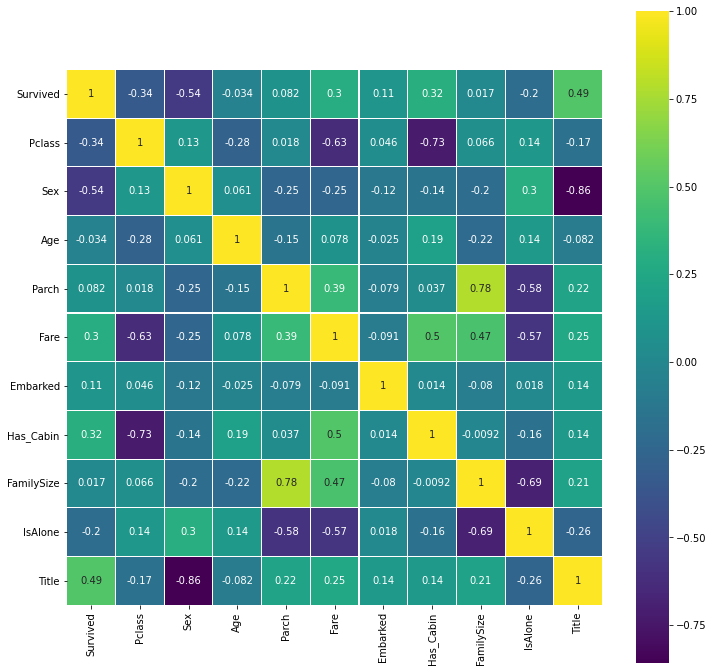

In [11]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [12]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])
# Since "Survived" is a binary class (0 or 1), these metrics grouped by the Title feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived

# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [13]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])
# Since Survived is a binary feature, this metrics grouped by the Sex feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived
    
# sex_mapping = {{'female': 0, 'male': 1}} 

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

In [14]:
# Let's use our 'original_train' dataframe to check the sex distribution for each title.
# We use copy() again to prevent modifications in out original_train dataset
title_and_sex = original_train.copy()[['Name', 'Sex']]

# Create 'Title' feature
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

# Map 'Sex' as binary feature
title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Table with 'Sex' distribution grouped by 'Title'
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

# Since Sex is a binary feature, this metrics grouped by the Title feature represent:
    # MEAN: percentage of men
    # COUNT: total observations
    # SUM: number of men

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

In [0]:
# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [16]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

In [17]:
# Gini Impurity decrease of node for 'male' observations
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [18]:
# Gini Impurity decrease if node splited for 'female' observations
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [19]:
# Gini Impurity decrease if node splited by Sex
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

In [20]:
# Gini Impurity decrease of node for observations with Title == 1 == Mr
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [21]:
# Gini Impurity decrease if node splited for observations with Title != 1 != Mr
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [22]:
# Gini Impurity decrease if node splited for observations with Title == 1 == Mr
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

-0.14267004758907514

In [23]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))


 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.820412
         5          0.820412
         6          0.815943
         7          0.800262
         8          0.803658
         9          0.802534
        10          0.802522


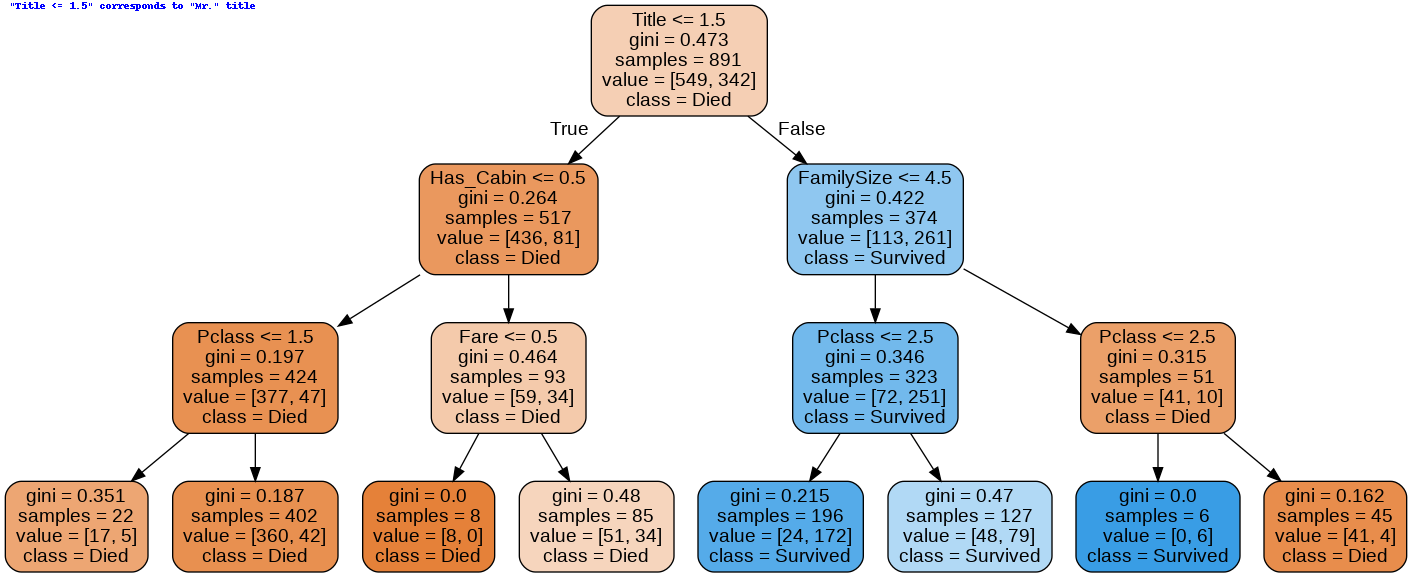

In [24]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

# Create Decision Tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
draw.text((10, 0), # Drawing offset (position)
          '"Title <= 1.5" corresponds to "Mr." title', # Text to draw
          (0,0,255)) # RGB desired color # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")

# Code to check available fonts and respective paths
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [25]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

82.38